In [1]:
import os
import time

import numpy as np

from matplotlib import pyplot as plt

from skimage import io as skio, color as skcolor

from adaptive_knn import AdaptiveKNN
from parallel import GridParallel

In [2]:
# replace the path in the following line with the path to the Tiny ImageNet images
tiny_imagenet_test_collection = skio.imread_collection(os.path.expanduser('~/opt/data/tiny-imagenet-200/test/images/*.JPEG'))
tiny_imagenet = np.zeros((len(tiny_imagenet_test_collection), 64 * 64 * 3))
for i, img in enumerate(tiny_imagenet_test_collection):
    if img.ndim == 2:
        img = skcolor.gray2rgb(img)
    tiny_imagenet[i, :] = img.ravel()
tiny_imagenet /= tiny_imagenet.max()
tiny_imagenet.shape

(10000, 12288)

In [3]:
def run_subsampled_knn(data_matrix, n, k, h, delta, which_alpha, alpha_c=0.75):
    
    Y = data_matrix[np.random.choice(data_matrix.shape[0], size=n, replace=False), :].copy()
    x = data_matrix[np.random.choice(data_matrix.shape[0]), :].copy()
    
    start_t = time.time()
    top_k, next_h, n_iters = AdaptiveKNN(Y, k, h, delta, which_alpha, alpha_c).query(x)
    activeknn_t = time.time() - start_t
    
    start_t = time.time()
    dists = np.linalg.norm(Y - x[None, :], axis=1)
    idx = np.argsort(dists)
    naiveknn_t = time.time() - start_t

    active_res = set(z[1] for z in (top_k + next_h))
    true_res = set(idx[:k])
    
    return len(active_res & true_res), n_iters, activeknn_t, naiveknn_t

def run_random_subspace_knn(m, d, n, k, h, delta, which_alpha, alpha_c=0.75):
    
    Y_low = np.random.randn(n, d)
    Y_low /= np.linalg.norm(Y_low, axis=1)[:, None]
    
    # approximately project to random subspace, then re-normalize
    Q = np.random.randn(d, m)
    Q /= np.linalg.norm(Q, axis=1)[:, None]
    Y = Y_low @ Q
    
    x = np.random.randn(d) @ Q
    x /= np.linalg.norm(x)
    
    xy_scale = max(np.abs(Y).max(), np.abs(x).max()) * 2
    Y /= xy_scale
    x /= xy_scale
    
    start_t = time.time()
    top_k, next_h, n_iters = AdaptiveKNN(Y, k, h, delta, which_alpha, alpha_c).query(x)
    activeknn_t = time.time() - start_t
    
    start_t = time.time()
    dists = np.linalg.norm(Y - x[None, :], axis=1)
    idx = np.argsort(dists)
    naiveknn_t = time.time() - start_t

    active_res = set(z[1] for z in (top_k + next_h))
    true_res = set(idx[:k])
    
    return len(active_res & true_res), n_iters, activeknn_t, naiveknn_t

In [4]:
m = tiny_imagenet.shape[1]
ps = [10, 100, 1000] #[10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
n = 1000
k = 10
h = 10
delta = 1e-3
which_alpha = 'alternative'
alpha_cs_ti = np.logspace(-3, 0, 13)
alpha_cs = np.logspace(-5, -2, 13)

n_trials = 20

res_tiny_imagenet = GridParallel(n_jobs=7, verbose=1)(run_subsampled_knn, n_trials*[tiny_imagenet], [n], [k], [h], [delta], [which_alpha], alpha_cs_ti)
res_subspace = GridParallel(n_jobs=7, verbose=1)(run_random_subspace_knn, [m]*n_trials, ps, [n], [k], [h], [delta], [which_alpha], alpha_cs)

Number of tasks: 260.


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   43.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  3.6min


Number of tasks: 780.


[Parallel(n_jobs=7)]: Done 260 out of 260 | elapsed:  5.2min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   21.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  6.0min
[Parallel(n_jobs=7)]: Done 780 out of 780 | elapsed: 11.1min finished


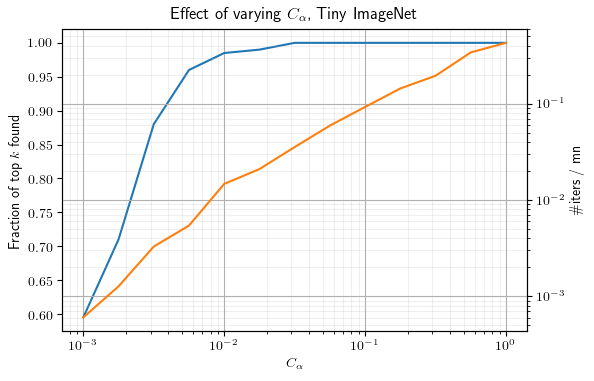

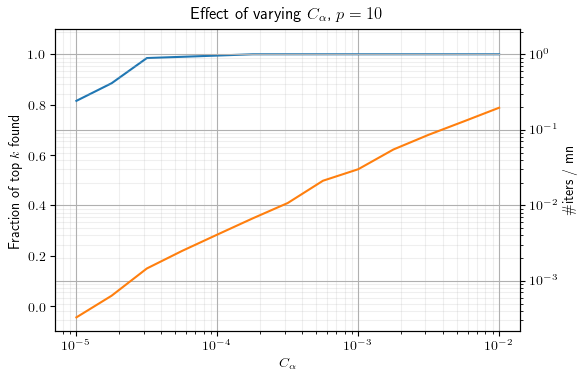

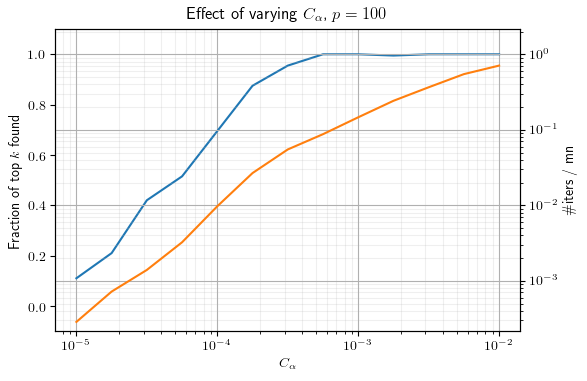

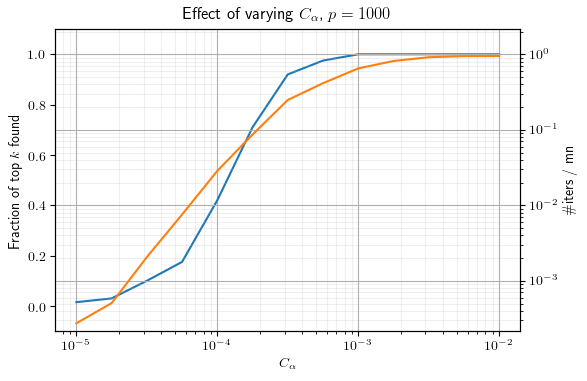

In [5]:
res_tiny_imagenet_np = np.array(res_tiny_imagenet)
res_subspace_np = np.array(res_subspace)

p_recovereds = res_tiny_imagenet_np[:, 0, 0, 0, 0, 0, :, 0].mean(0) / k
n_iter_fracs = res_tiny_imagenet_np[:, 0, 0, 0, 0, 0, :, 1].mean(0) / n / m

plt.rc('text', usetex=True)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax1 = plt.subplots(dpi=100)

ax1.semilogx(alpha_cs_ti, p_recovereds, c=color_cycle[0])
plt.ylabel('Fraction of top $k$ found')
plt.xlabel(r'$C_\alpha$')
plt.title(r'Effect of varying $C_\alpha$, Tiny ImageNet')
plt.grid(axis='x')
plt.grid(which='minor', axis='x', alpha=0.2)

ax2 = ax1.twinx()
ax2.loglog(alpha_cs_ti, n_iter_fracs, c=color_cycle[1])
plt.ylabel('\#iters / mn')
plt.grid(True)
plt.grid(which='minor', alpha=0.2)
plt.show()

for i, p in [(ps.index(p), p) for p in [10, 100, 1000]]:
    recalls = res_subspace_np[:, i, 0, 0, 0, 0, 0, :, 0].mean(0) / k
    n_iter_fracs = res_subspace_np[:, i, 0, 0, 0, 0, 0, :, 1].mean(0) / n / m

    plt.rc('text', usetex=True)
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax1 = plt.subplots(dpi=100)

    ax1.semilogx(alpha_cs, recalls, c=color_cycle[0])
    ax1.set_ylim(-0.1, 1.1)
    plt.ylabel('Fraction of top $k$ found')
    plt.xlabel(r'$C_\alpha$')
    plt.title(r'Effect of varying $C_\alpha$, $p = %g$' % p)
    plt.grid(axis='x')
    plt.grid(which='minor', axis='x', alpha=0.2)

    ax2 = ax1.twinx()
    ax2.loglog(alpha_cs, n_iter_fracs, c=color_cycle[1])
    plt.ylabel('\#iters / mn')
    ax2.set_ylim(1e-4 * 10**(1/3), 10**(1/3))
    plt.grid(True)
    plt.grid(which='minor', alpha=0.2)
    plt.show()

In [6]:
os.makedirs('results', exist_ok=True)
np.savez(os.path.join('results', 'tiny_imagenet_subspaces.npz'), 
         res_tiny_imagenet_np=res_tiny_imagenet_np,
         res_subspace_np=res_subspace_np,
         n=n,
         m=m,
         ps=ps,
         k=k,
         h=h,
         delta=delta,
         n_trials=n_trials,
         which_alpha=which_alpha,
         alpha_cs=alpha_cs,
         alpha_cs_ti=alpha_cs_ti)